# Celltype refinement

Cell types are defined as concepts with hierarchical relationships. For example, CD4+ T cell is a type of T cell. Therefore, when performing omics cell annotation, the results of cell annotation at different levels are often determined according to requirements. This makes the sub-celltype refinement a very important task. In some analyses, after routine annotation, further subdivision of cell subsets is required. Here, we demonstrate how to use BRICK for the sub-celltype refinement, further dividing pancreatic endocrine cell into pancreatic PP cell and pancreatic D cell.

## Load packages and data

In [1]:
import BRICK
import scanpy as sc

url = "neo4j://10.224.28.66:7687"
auth = ("neo4j", "bmVvNGpwYXNzd29yZA==")  

BRICK.config(url=url, auth=auth)

Graph database has been configured and initialized successfully.


In [2]:
adata = sc.read('../../../KG_annotation/adata_new1.h5ad')
adata.X = adata.layers['lognorm'].copy()

## subset the dataset

subset the dataset that need to be further refined. In this case, the cell type columns is KGannotator2, and the cell group that need to further refined is somatostatin secreting cell according to previous annotation.

In [3]:
adata_sub = adata[adata.obs['KGannotator2'] == 'somatostatin secreting cell'].copy()

## sub-celltype refinement

Obviouslly, *somatostatin secreting cell* is a general cell type. From cell type annotation result we noticed that both *pancreatic D cell* and *pancreatic PP cell* are candidata cell type, which indicate these cell cluster might be a mixture of these two cell types. Thus, we use these two cell type as candidate celltypes.

In [4]:
candidate_celltypes = ['pancreatic D cell', 'pancreatic PP cell']

query_df = BRICK.qr.query_neighbor(candidate_celltypes, relation='marker_of', target_entity_type='Gene')
query_df.head()

,path.0.def,path.0.id,path.0.name,path.0.synonym,path.0.type,path.1,path.1.condition,path.1.info_source,path.1.info_source_length,path.1.original_relation,path.1.relation,path.1.relation_confidence,path.2.def,path.2.id,path.2.name,path.2.synonym,path.2.type
0,A D cell located in the pancreas. Peripherally placed within the islets like type A cells; contains somatostatin.<xref>BTO:0000803|FMA:70587</xref>,CL:0000173,pancreatic D cell,D-cell of pancreatic islet|delta cell of islet|delta cell of pancreatic islet|pancreatic D-cell|pancreatic delta cell|somatostatin-secreting pancreatic cell,Cell,marker_of,[UBERON:0001264],[Cell_Taxonomy:PanglaoDB],1,[marker_of],marker_of,[1],Sstr2 somatostatin receptor 2<loc>:11 E2|11 79.05 cM<xref>MGI:98328|ENSEMBL:ENSMUSG00000047904</xref>,NCBI:20606,Sstr2,SRIF-1|SS2R|SSTR-2|Smstr-2|Smstr2|Somatostatin receptor type 2|sst2,Gene
1,A PP cell located in the islets of the pancreas.<xref>MESH:D050418|FMA:70588|BTO:0000805</xref>,CL:0002275,pancreatic PP cell,pancreatic polypeptide-secreting cell|PP cell of pancreatic islet|PP-cell of pancreatic islet,Cell,marker_of,[UBERON:0001264],[SCT000000966],1,[DEG_of],marker_of,[0.471],Hdac6 histone deacetylase 6<loc>:X A1.1|X 3.58 cM<xref>MGI:1333752|ENSEMBL:ENSMUSG00000031161</xref>,NCBI:15185,Hdac6,Hd6|Hdac5|Histone deacetylase 6|Sfc6|mHDA2,Gene
2,A D cell located in the pancreas. Peripherally placed within the islets like type A cells; contains somatostatin.<xref>BTO:0000803|FMA:70587</xref>,CL:0000173,pancreatic D cell,D-cell of pancreatic islet|delta cell of islet|delta cell of pancreatic islet|pancreatic D-cell|pancreatic delta cell|somatostatin-secreting pancreatic cell,Cell,marker_of,[UBERON:0001264],[Cell_Taxonomy:CellMarker:PMID:27693023],1,[marker_of],marker_of,[1],apoptosis antagonizing transcription factor<loc>:17q12<xref>OMIM:608463|HGNC:19235|ENSEMBL:ENSG00000275700</xref>,NCBI:26574,AATF,BFR2|CHE-1|CHE1|DED,Gene
3,A PP cell located in the islets of the pancreas.<xref>MESH:D050418|FMA:70588|BTO:0000805</xref>,CL:0002275,pancreatic PP cell,pancreatic polypeptide-secreting cell|PP cell of pancreatic islet|PP-cell of pancreatic islet,Cell,marker_of,[UBERON:0001264],"[SCT000000876, SCT000000969]",2,"[DEG_of, DEG_of]",marker_of,"[0.444, 0.45799999999999996]",ABCB1 ATP binding cassette subfamily B member 1<loc>:7q21.12<xref>ENSEMBL:ENSG00000085563|OMIM:171050|HGNC:40</xref>,NCBI:5243,ABCB1,ABC20|CD243|CLCS|GP170|MDR1|Multidrug resistance protein 1|P-GP|PGY1|p-170,Gene
4,A PP cell located in the islets of the pancreas.<xref>MESH:D050418|FMA:70588|BTO:0000805</xref>,CL:0002275,pancreatic PP cell,pancreatic polypeptide-secreting cell|PP cell of pancreatic islet|PP-cell of pancreatic islet,Cell,marker_of,[UBERON:0001264],"[SCT000000859, SCT000000859]",2,"[DEG_of, DEG_of]",marker_of,"[0.542, 0.542]",ABCC9 ATP binding cassette subfamily C member 9<loc>:12p12.1<xref>ENSEMBL:ENSG00000069431|HGNC:60|OMIM:601439</xref>,NCBI:10060,ABCC9,"ABC37|ATFB12|ATP-binding cassette sub-family C member 9|CANTU|CMD1O|IDMYS|SUR2|Sulfonylurea receptor 2, Kir6.2",Gene


### get the gene_list by intersection of KG and Omics

In [5]:
genelist = list(set(adata_sub.var_names) & set(query_df['path.2.name']))

adata_sub = adata_sub[:, genelist].copy()

query_df = query_df.loc[query_df['path.2.name'].isin(genelist)]

## Construct a graph combine Knowledge Graph with Omics

In [41]:
nxg = BRICK.pp.combine_graph(adata=adata_sub, df=query_df, kg_reverse_direct=True, cell_neighbor=True)
len(nxg.nodes())

186

(T):   0%|                                                                                    | 0/1200 [00:00<?, ?it/s]D:\Anaconda\envs\py310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'dropout_adj' is deprecated, use 'dropout_edge' instead
  warnings.warn(out)
(T): 100%|██████████████████████████████████████████████████████████████| 1200/1200 [00:17<00:00, 69.80it/s, loss=3.09]


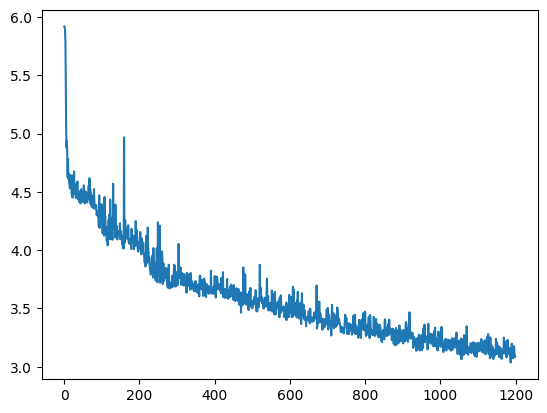

In [42]:
model = BRICK.emb.GRACE_model(nxg=nxg, lr=0.01)
model.fit(epoches=1200)
model.plot_loss()

In [43]:
adata_graph = model.get_result()

D:\Anaconda\envs\py310\lib\site-packages\anndata\_core\aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


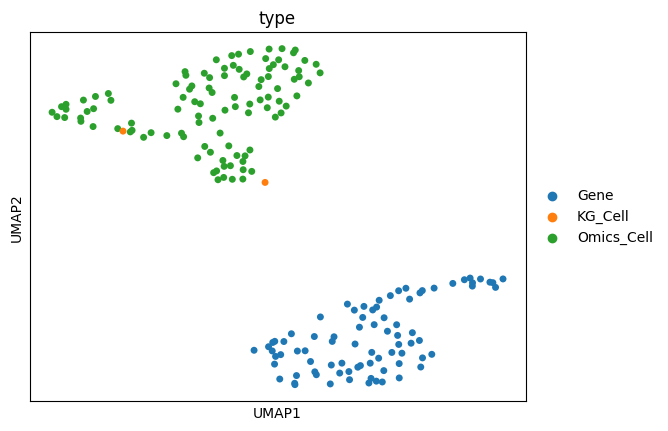

In [44]:
sc.pl.umap(adata_graph, color = 'type', s=100)

## use euclidean distance to get sub-celltype refinement

In [45]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [46]:
adata_graph_KG = adata_graph[adata_graph.obs['type'] == 'KG_Cell']
adata_graph_Omics = adata_graph[adata_graph.obs['type'] == 'Omics_Cell']


emb1 = adata_graph_KG.X
emb2 = adata_graph_Omics.X
#dist = cosine_similarity(emb1, emb2)
dist = np.array([ np.linalg.norm(emb2 - x, axis=1) for x in emb1])

dist_map = pd.DataFrame(dist)
dist_map.index = adata_graph_KG.obs_names
dist_map.columns = adata_graph_Omics.obs_names

In [47]:
for x in dist_map.T:
    adata_sub.obs[x+'_dist'] = dist_map.T[x]

adata_sub.obs['dist'] = adata_sub.obs['pancreatic D cell_dist'] - adata_sub.obs['pancreatic PP cell_dist']

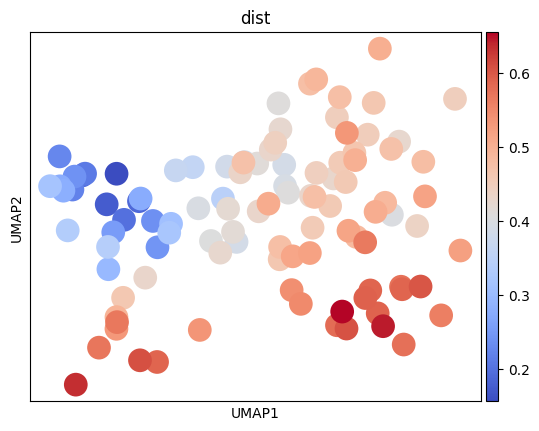

In [48]:
sc.pl.umap(adata_sub, color='dist', cmap='coolwarm') 

## find most approperate threshold

<Axes: xlabel='dist', ylabel='Count'>

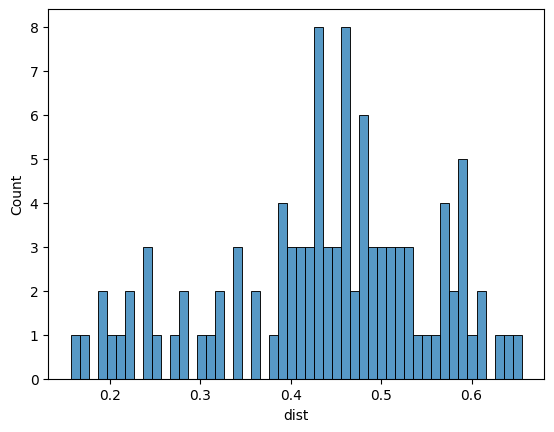

In [49]:
sns.histplot(adata_sub.obs['dist'], bins=50)

In [50]:
from skimage.filters import threshold_otsu
threshold_otsu = threshold_otsu(adata_sub.obs['dist'].to_numpy())

In [51]:
threshold_otsu

0.3660886

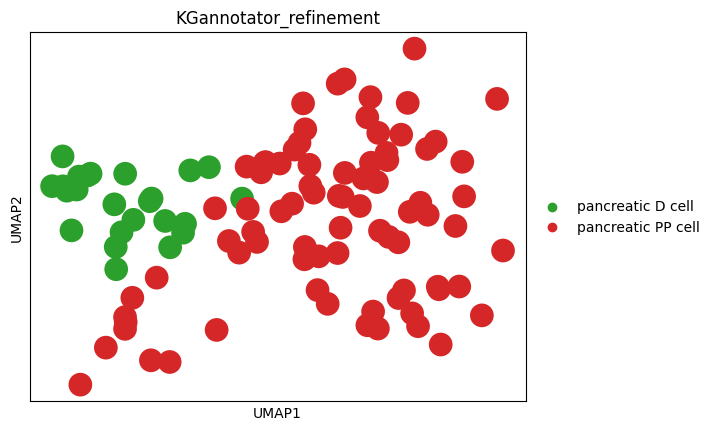

In [52]:
adata_sub.obs['KGannotator_refinement'] = ['pancreatic PP cell' if d > threshold_otsu else 'pancreatic D cell' for d in adata_sub.obs['dist'] ]
sc.pl.umap(adata_sub, color='KGannotator_refinement') 

## record refinement result to original anndata

In [18]:
adata.obs["KGannotator_refinement"] = adata.obs['KGannotator2'].copy().astype(str)
adata.obs.loc[adata_sub.obs.index, 'KGannotator_refinement'] = adata_sub.obs['KGannotator_refinement']

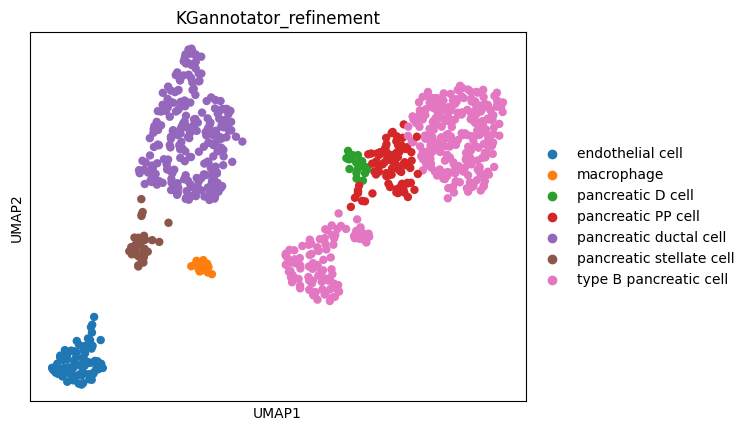

In [19]:
sc.pl.umap(adata, color='KGannotator_refinement') 